In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
physical_devices = tf.config.list_physical_devices('CPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# Building Data Loading Functions

In [5]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])  
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

<img src="Input Preprocessing.png" alt="Input Video Cropping" width="500">


In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [58]:
print(char_to_num(['t','e','a','m','1','0']))
print(num_to_char([1,  2,  3, 4, 5, 6,]))

tf.Tensor([20  5  1 13 30  0], shape=(6,), dtype=int64)
tf.Tensor([b'a' b'b' b'c' b'd' b'e' b'f'], shape=(6,), dtype=string)


In [11]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [12]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments


In [64]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [65]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\' )[-1].split('.')[0]

'bbal6n'

In [66]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

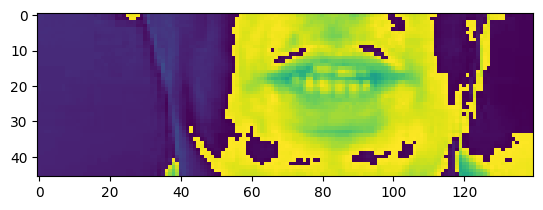

In [73]:
plt.imshow(frames[40])

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [22]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# Data Pipeline - Used for loading Data into the Model

In [23]:
from matplotlib import pyplot as plt

In [24]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(400)
test = data.skip(400)

In [25]:
print("Test Dataset Length =", len(test))

Test Dataset Length = 100


In [ ]:
frames, alignments = data.as_numpy_iterator().next() 

In [29]:
print("Number of videos =", len(frames))
print("Corresponding alignments =", alignments)


Number of videos = 2
Corresponding alignments = [[16 12  1  3  5 39 18  5  4 39  9 14 39 16 39 15 14  5 39 19 15 15 14  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [16 12  1  3  5 39 23  8  9 20  5 39  2 25 39 17 39 19  9 24 39 16 12  5
   1 19  5  0  0  0  0  0  0  0  0  0  0  0  0  0]]


In [78]:
sample = data.as_numpy_iterator()
val = sample.next(); val[0]

array([[[[[1.5011237 ],
          [1.4645109 ],
          [1.4645109 ],
          ...,
          [0.4393533 ],
          [0.4393533 ],
          [0.4393533 ]],

         [[1.5377365 ],
          [1.4645109 ],
          [1.3912854 ],
          ...,
          [0.4393533 ],
          [0.4393533 ],
          [0.4393533 ]],

         [[1.5011237 ],
          [1.5011237 ],
          [1.5011237 ],
          ...,
          [0.32951495],
          [0.32951495],
          [0.32951495]],

         ...,

         [[1.0983832 ],
          [1.0617704 ],
          [1.0617704 ],
          ...,
          [0.10983832],
          [0.10983832],
          [0.10983832]],

         [[1.0617704 ],
          [1.0617704 ],
          [1.0617704 ],
          ...,
          [0.07322555],
          [0.07322555],
          [0.07322555]],

         [[1.0617704 ],
          [1.0617704 ],
          [1.0617704 ],
          ...,
          [0.03661278],
          [0.03661278],
          [0.03661278]]],


        [[[1.5743

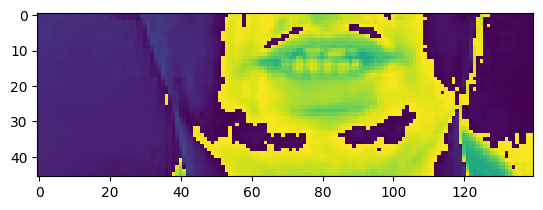

In [31]:
plt.imshow(val[0][0][40])

In [33]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at g one again'>

# 3. Design the Deep Neural Network

In [34]:
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [35]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [36]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))
# 75,23,70,128

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))
# 75,11,35,256

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))
# 75,5,17,75

model.add(TimeDistributed(Flatten()))
# 75, 6375

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

<img src="ModelDiag.png" alt="SpeakSee - Model Architecture" width="1350">


In [37]:
print("Input Shape =",model.input_shape)
print("Output Shape =", model.output_shape)

Input Shape = (None, 75, 46, 140, 1)
Output Shape = (None, 75, 41)


In [38]:
yhat = model.predict(val[0])

1/1 [==============================] - 9s 9s/step


In [39]:
tf.argmax(yhat[0],axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([28, 28, 22, 22, 22, 22, 22, 22, 22,  4, 11, 11, 11, 11, 11, 11, 11,
       11,  4,  4,  4, 11, 11, 11, 11, 11, 11, 11,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11, 11, 11, 11, 11], dtype=int64)>

In [40]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'??vvvvvvvdkkkkkkkkdddkkkkkkkddddddddddddddddddddddddkkkkkkkkkkkkkkkkkkkkkkk'>

# 4. Setup Training Options and Train

In [44]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [45]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [46]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [47]:
from tensorflow.keras.optimizers.legacy import Adam 
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [48]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [44]:
#model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [49]:
model.load_weights('models/checkpoint')
# print(model.summary())

In [50]:
test_data = test.as_numpy_iterator()
sample = test_data.next()
yhat = model.predict(sample[0])

1/1 [==============================] - 7s 7s/step


In [51]:
print("REAL TEXT:")
real_text = [
    tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') 
    for sentence in sample[1]
]
print(real_text)

predicted_text = [
    tf.strings.reduce_join([num_to_char(word) for word in np.argmax(pred, axis=-1)]).numpy().decode('utf-8')
    for pred in yhat
]
print("\nPREDICTED TEXT:")
print(predicted_text)


REAL TEXT:
['set green in v zero now', 'place white with r zero please']

PREDICTED TEXT:
['set   green  in   v   zerooo    nnooowwww', 'placce white  withh r   zerooo   ppplleeaassseee']


In [52]:
print('REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green in v zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white with r zero please'>]

In [53]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy() # how to the extra letters get removed

In [54]:
print('PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set green in v zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place white with r zero please'>]

In [ ]:
import numpy as np
import tensorflow as tf
from jiwer import wer 

# Load the model weights
model.load_weights('models/checkpoint')
seed = 1
# Initialize lists to store real and predicted texts
all_real_text = []
all_predicted_text = []

# Iterate over all batches in the test dataset
for sample in test:
    # Make a prediction for each batch
    yhat = model.predict(sample[0])

    # Convert real text
    real_text = [
        tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8')
        for sentence in sample[1]
    ]
    all_real_text.extend(real_text)

    # Decode the model predictions
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
    
    # Convert decoded predictions to text
    predicted_text = [
        tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8')
        for sentence in decoded
    ]
    all_predicted_text.extend(predicted_text)

# Calculate Word Error Rate (WER) for the entire dataset
wer_scores = [wer(rt, pt) for rt, pt in zip(all_real_text, all_predicted_text)]
average_wer = np.mean(wer_scores)
print(f"\nAverage WER for the entire dataset: {average_wer:.4f}")

# Calculate simple accuracy (exact match) for the entire dataset
correct_predictions = sum(rt == pt for rt, pt in zip(all_real_text, all_predicted_text))
accuracy = correct_predictions / len(all_real_text)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


1/1 [==============================] - 3s 3s/step

Average WER for the entire dataset: 0.0129
Overall Accuracy: 93.00%


# Test on a Video

In [52]:
sample = load_data(tf.convert_to_tensor('D:\Python Code\data\s1\srwi4p.mpg'))

In [53]:
print('REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set red with i four please'>]

In [54]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 2s 2s/step


In [55]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [56]:
print('PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'set red with i four please'>]